Importing the model and the cleaned data from PART1

In [165]:
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings("ignore")


# Load the saved model
xgb_model = joblib.load('models/TDS-PART1-MODEL.pkl')

# Load the same dataset to ensure consistency
dtf = pd.read_csv('data/cleaned_data.csv')



In [166]:
dtf.head()
no_change_dtf = dtf.copy()

# Error Analysis & Work Plan

## Introduction
As observed in the previous analysis, the baseline model provided a moderate level of performance, indicating room for improvement. The model achieved the following results:

- **Mean Absolute Error (MAE):** 20,018.74  
- **Mean Squared Error (MSE):** 1,092,283,996.64  
- **Root Mean Squared Error (RMSE):** 33,049.72  
- **R² Score:** 0.53  

While these scores represent a reasonable starting point, they highlight several weaknesses that limit the model's ability to generalize and perform well across all data points. Our primary goal in this notebook is to explore creative and effective approaches to improving these metrics, with a particular focus on boosting the **R² score** and reducing both **RMSE** and **MAE**.

---

## Base-Model Weaknesses & Error Analysis Conclusions
From the error analysis:

### Sub-Optimal Performance
- The **R² score** of 0.53 suggests the model is explaining just over half of the variance in the data, which indicates sub-optimal performance.  
- The **RMSE** (33,049.72) and **MAE** (20,018.74) highlight significant prediction errors, especially for high-value targets.

### Skewed Features
- Many features exhibit **right-skewed distributions**, which may be distorting the model's ability to predict accurately.  

### Outliers
- Several features with extreme prediction errors, indicate the presence of influential outliers that are negatively impacting the model's predictions.

### Categorical Features
- Categorical features not effectively encoded , limiting the model's capacity to capture meaningful relationships.

---

## Work Plan
To address these issues, we propose the following structured plan:

### 1. Skewed Features
- **Transform Skewed Data**:  
  - Apply **Box-Cox transformation** to reduce the effect of skewed distributions.  

### 2. Outlier Handling
  - Identify outliers using **IQR rule**.
  - Either cap outliers to reasonable limits or remove them if they excessively distort the dataset.

### 3. Feature Engineering
- **Categorical Feature Effective Encoding**:  
  - Use **one-hot encoding** for categorical variables to enable the model to better understand the relationships between these variables and the target.  
 

### Skewness Analysis

In this step, we evaluate the skewness of numerical columns to identify features with non-symmetric distributions. Skewness is a measure of how asymmetrical the distribution of a variable is. Features with high skewness (absolute skewness > 0.5) can negatively impact the performance of machine learning models, especially those sensitive to the scale and distribution of data.

The following steps were taken:
1. Selected relevant numerical columns for skewness analysis.
2. Calculated the skewness for each column.
3. Identified columns with moderate or high skewness (absolute skewness > 0.5).


In [167]:
# Select numerical columns correctly
numerical_columns = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']

# Calculate skewness for each numerical column
skewness = dtf[numerical_columns].skew()
skewed_columns = skewness[skewness.abs() > 0.5].index

print("Skewness of numerical columns:\n", skewness)
print("Skewed numerical columns:\n", skewed_columns)


Skewness of numerical columns:
 engine_hp          1.25
engine_cylinders   0.91
highway_mpg        7.76
city_mpg           7.09
popularity         1.63
dtype: float64
Skewed numerical columns:
 Index(['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg',
       'popularity'],
      dtype='object')


The results show that all selected numerical columns (`engine_hp`, `engine_cylinders`, `highway_mpg`, `city_mpg`, and `popularity`) exhibit skewness, with some features (e.g., `highway_mpg` and `city_mpg`) being highly skewed. These skewed features may require transformations to improve symmetry and make them more suitable for the machine learning model.


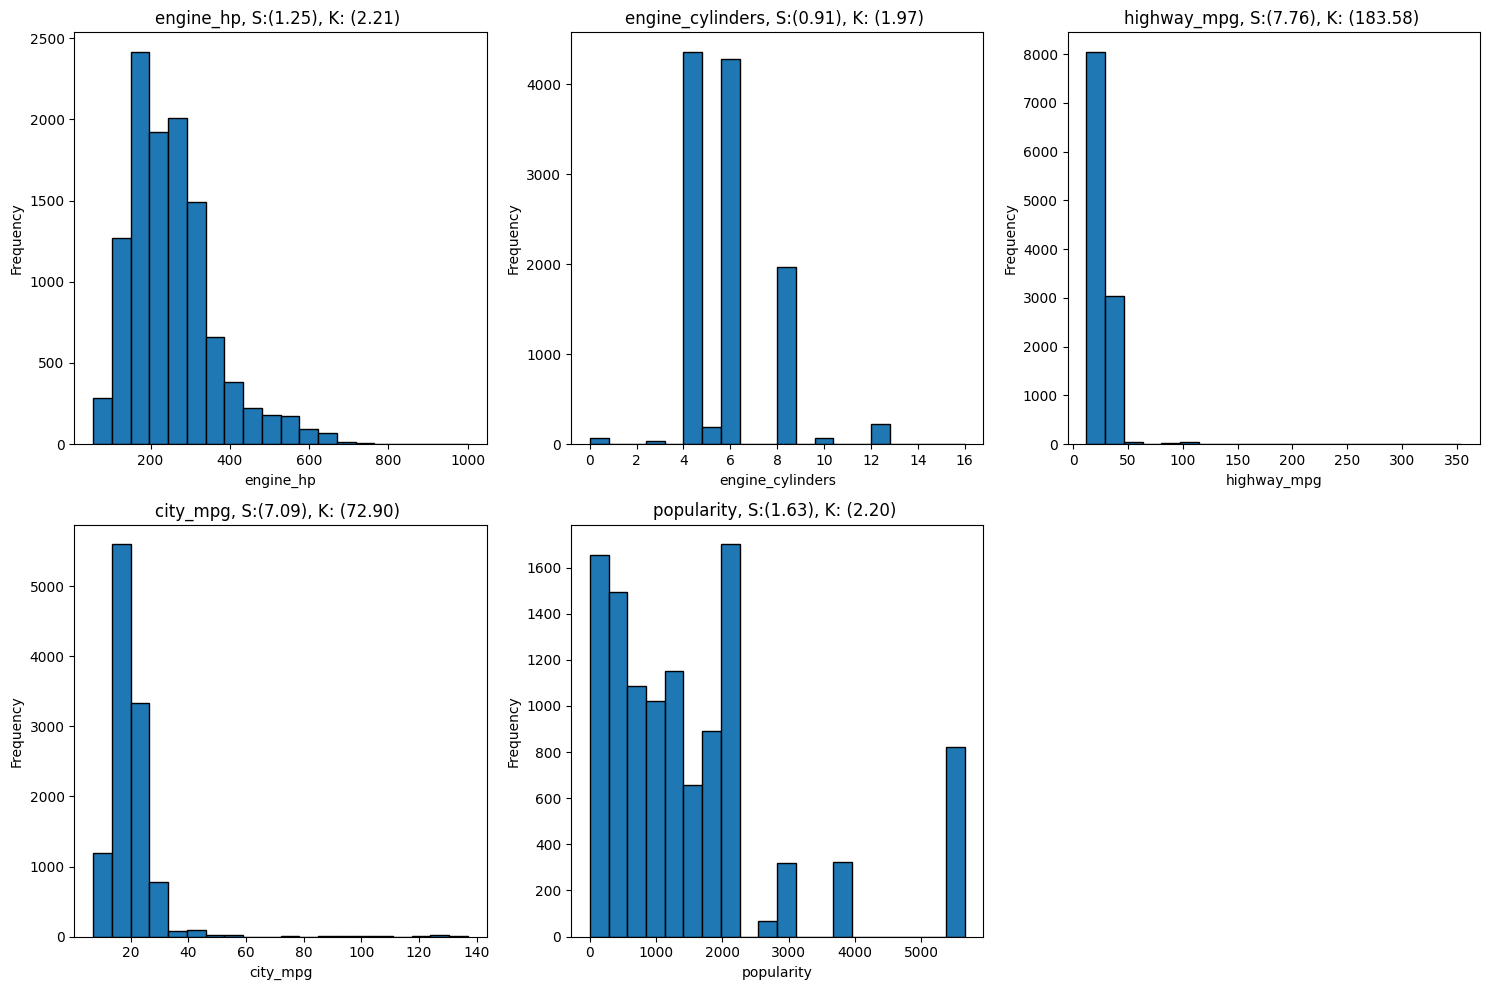

In [168]:
import matplotlib.pyplot as plt
def plot_histograms(numerical_columns):
    num_columns = len(numerical_columns)

    num_rows = int(np.ceil(num_columns / 3))
    num_cols = min(num_columns, 3)

        # create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5 * num_cols, 5 * num_rows))

    axes = axes.flatten()

        # loop through the columns and plot each histogram
    for i, column in enumerate(numerical_columns):
        axes[i].hist(dtf[column], bins=20, edgecolor='black')
        axes[i].set_title(f"{column}, S:({dtf[column].skew():.2f}), K: ({dtf[column].kurt():.2f}) ")
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    
plot_histograms(numerical_columns)

### Visualizing Skewness of Numerical Features

The histograms above depict the distributions of key numerical features in the dataset along with their skewness (S) and kurtosis (K) values:

1. **`engine_hp`**:
   - Skewness (S): 1.25 (moderately right-skewed)
   - Kurtosis (K): 2.21
   - The distribution is right-skewed, with most values concentrated below 400 horsepower and a long tail extending to higher values. This asymmetry suggests that a log transformation may help normalize the data.

2. **`engine_cylinders`**:
   - Skewness (S): 0.91 (moderately right-skewed)
   - Kurtosis (K): 1.97
   - The distribution is slightly skewed due to the high frequency of common values like 4, 6, and 8 cylinders. However, outliers beyond 12 cylinders are visible and may require treatment.

3. **`highway_mpg`**:
   - Skewness (S): 7.76 (highly right-skewed)
   - Kurtosis (K): 183.58
   - This feature is extremely right-skewed, with most values clustered below 50 miles per gallon and a very long tail. A transformation, such as log or Box-Cox, is critical to address this skewness.

4. **`city_mpg`**:
   - Skewness (S): 7.09 (highly right-skewed)
   - Kurtosis (K): 72.90
   - Similar to `highway_mpg`, the data is highly concentrated at lower values with a significant right skew. A transformation will help reduce this skewness and improve model performance.

5. **`popularity`**:
   - Skewness (S): 1.63 (moderately right-skewed)
   - Kurtosis (K): 2.20
   - The distribution is moderately skewed, with peaks at certain values. This could indicate specific popularity tiers or outliers that should be explored further.

---

### Observations
- **Skewed Distributions**: All features exhibit moderate to severe right-skewness, which can distort machine learning model performance.
- **Potential Transformations**: Highly skewed features like `highway_mpg` and `city_mpg` require transformations (e.g., log or Box-Cox) to improve normality.
- **Outlier Investigation**: Extreme values, especially in `engine_cylinders`, `highway_mpg`, and `city_mpg`, need to be examined and addressed to minimize their impact on the model.


### Box-Cox Transformation for Skewed Features

To address the skewness identified in numerical features, we applied the **Box-Cox transformation**.   

#### **Steps Taken**

1. **Handling Negative Values**:
   - Box-Cox transformations require all input values to be positive. For columns with non-positive values, a positive shift was applied to ensure all values meet this requirement.

2. **Applying Box-Cox Transformation**:
   - The transformation was applied to each skewed column, optimizing the parameter `λ` (lambda) for each feature to normalize its distribution.
   - The lambda values were stored for potential future reference.

3. **Recalculating Skewness**:
   - After transformation, the skewness of the numerical features was recalculated to verify the effectiveness of the transformation. All features now have skewness values close to **0**, indicating near-symmetric distributions.

4. **Visualizing Post-Transformation Distributions**:
   - Histograms were plotted for the numerical features after transformation to visually inspect the improvement in symmetry.


Box-Cox transformation applied to skewed columns.
Skewness After Box-Cox Transformation:
 engine_hp           0.00
engine_cylinders    0.13
highway_mpg        -0.05
city_mpg           -0.09
popularity         -0.02
dtype: float64


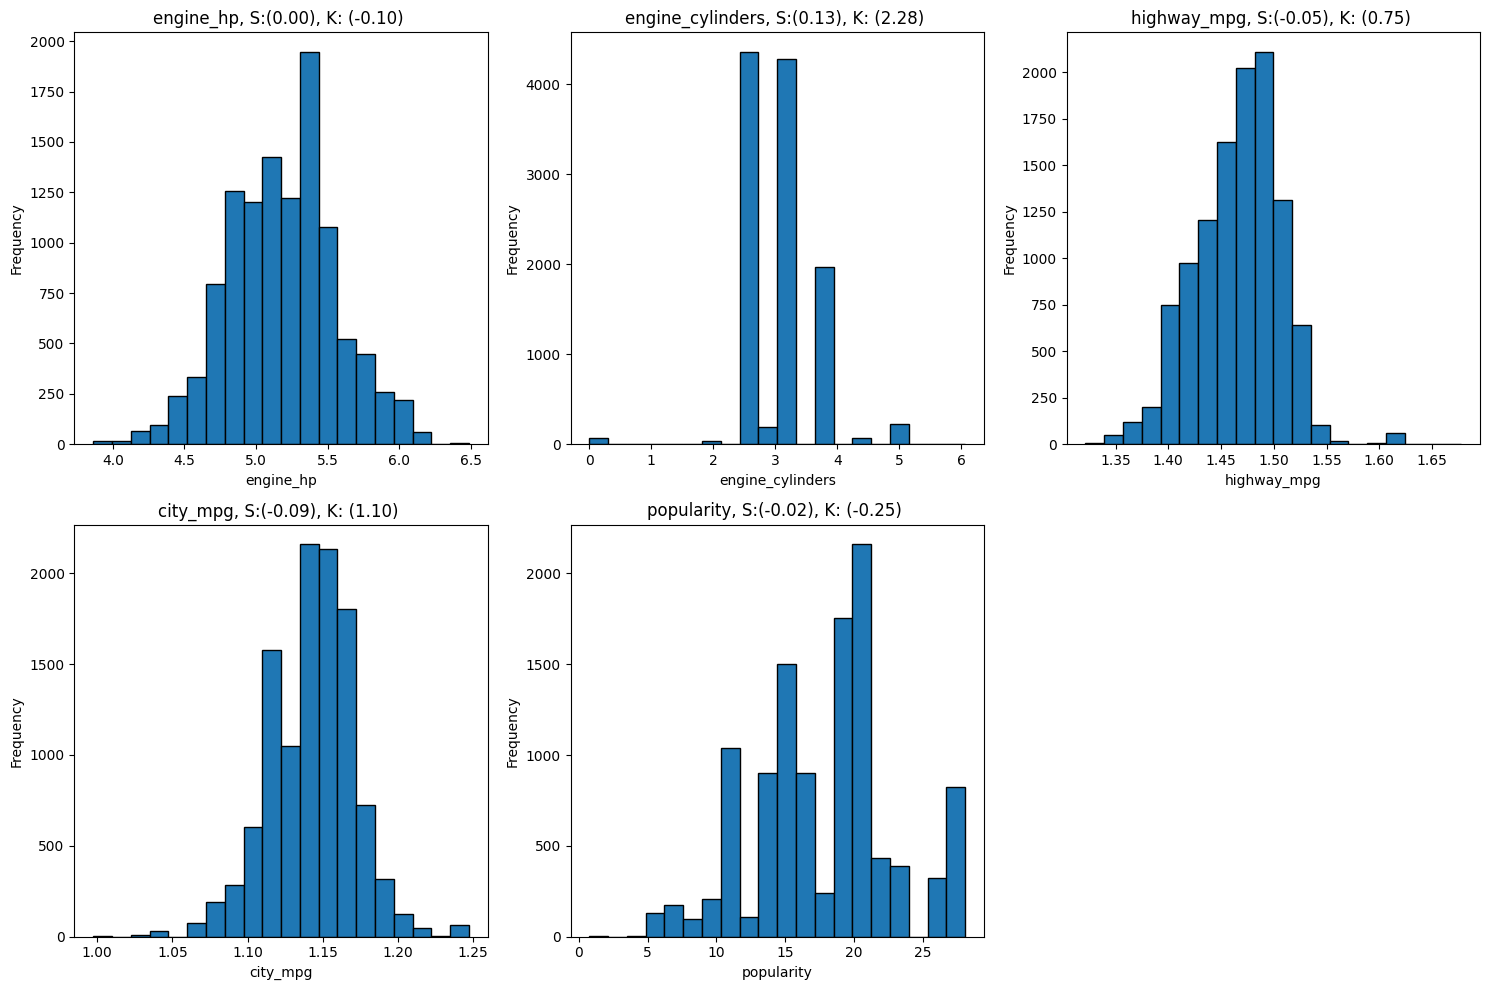

In [169]:
from scipy.stats import boxcox

for col in skewed_columns:
    if (dtf[col] <= 0).any():
        min_val = dtf[col].min()
        shift = abs(min_val) + 1  # Ensure all values are positive
        dtf[col] += shift

# Step 3: Apply Box-Cox transformation
boxcox_lambdas = {}  # Dictionary to store lambda values for each column
for col in skewed_columns:
    # Apply Box-Cox transformation
    dtf[col], lmbda = boxcox(dtf[col])
    boxcox_lambdas[col] = lmbda  # Store lambda for each column

print("Box-Cox transformation applied to skewed columns.")

# Step 4: Verify skewness after transformation
new_skewness = dtf[skewed_columns].skew()
print("Skewness After Box-Cox Transformation:\n", new_skewness)

plot_histograms(numerical_columns)


#### **Results After Transformation**
- The skewness values after the Box-Cox transformation are as follows:
  - **`engine_hp`**: 0.000253 (almost symmetric)
  - **`engine_cylinders`**: 0.132054 (nearly symmetric)
  - **`highway_mpg`**: -0.050889 (nearly symmetric)
  - **`city_mpg`**: -0.093090 (nearly symmetric)
  - **`popularity`**: -0.022833 (nearly symmetric)


### Outlier Detection: Visualization Before Handling

To identify and address these anomalies, boxplots were used to visualize the presence of outliers in numerical features.

#### **Steps in the Code**:
1. **Define Visualization Function**:
   - The function `visualize_outliers` takes a DataFrame and a list of numerical columns as input.
   - It creates boxplots for each column in a grid layout to provide a clear view of outliers.

2. **Include `msrp` in Analysis**:
   - The `msrp` (target variable) was included in the visualization to detect and understand its outliers.

3. **Visualize Outliers**:
   - Boxplots were generated for each numerical column to highlight data points that fall outside the interquartile range (IQR). These points are potential outliers.


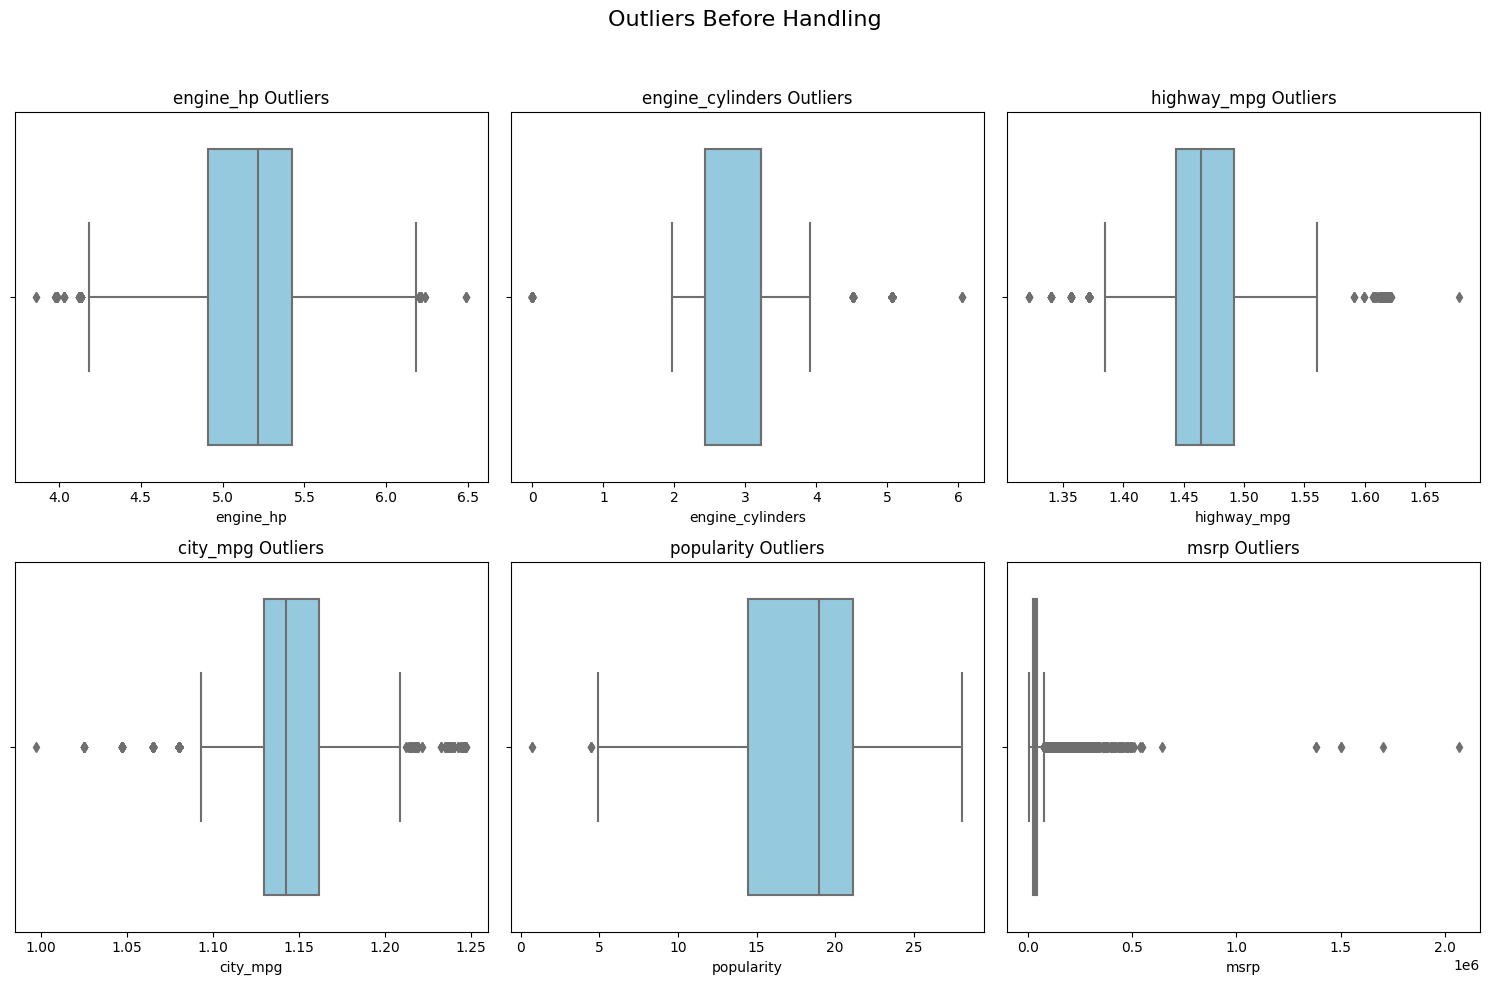

In [170]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def visualize_outliers(dtf, numerical_columns, title):
    """
    Visualizes outliers in the numerical columns using boxplots in a grid layout.

    Args:
        dtf: DataFrame containing the data.
        numerical_columns: List of numerical columns to plot.
        title: Title of the plot.
    """
    num_columns = len(numerical_columns)
    num_rows = int(np.ceil(num_columns / 3))
    num_cols = min(num_columns, 3)

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5 * num_cols, 5 * num_rows))
    axes = axes.flatten()

    # Plot each column in the grid
    for i, col in enumerate(numerical_columns):
        sns.boxplot(data=dtf, x=col, ax=axes[i], color='skyblue')
        axes[i].set_title(f"{col} Outliers")

    # Turn off unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    # Add a main title and adjust layout
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

before_dtf = dtf.copy()
numerical_columns_with_msrp = numerical_columns + ['msrp']
visualize_outliers(before_dtf, numerical_columns_with_msrp, "Outliers Before Handling")


#### **Observations**:
- **`engine_hp`**:
  - A few data points lie beyond the whiskers, indicating moderate outliers.
- **`engine_cylinders`**:
  - Outliers are present at higher cylinder counts (e.g., >6), which could distort model predictions.
- **`highway_mpg` & `city_mpg`**:
  - Both features have several outliers, particularly at higher values. These extreme points could affect the accuracy of the model.
- **`popularity`**:
  - Some moderate outliers exist, though the distribution is relatively compact.
- **`msrp`**:
  - Significant outliers are present in the upper range, likely corresponding to high-end luxury cars. These may need special handling to prevent skewed model training.


### Outlier Handling: Removing Extreme Values

To address the outliers identified in the previous step, we applied the **Interquartile Range (IQR)** method.

#### **Steps in the Code**:
1. **Calculate IQR**:
   - For each numerical column, the first quartile (Q1) and third quartile (Q3) were calculated.
   - The **Interquartile Range (IQR)** was computed as `IQR = Q3 - Q1`.

2. **Define Outlier Bounds**:
   - Lower bound: `Q1 - 1.5 * IQR`
   - Upper bound: `Q3 + 1.5 * IQR`
   - Data points falling outside these bounds are considered outliers.

3. **Filter Data**:
   - Rows with values outside the lower and upper bounds were removed from the dataset for the corresponding column.
   - This ensures only reasonable data points are retained for further analysis and modeling.

4. **Re-Visualize Outliers**:
   - After removing outliers, the updated distributions were visualized using boxplots to confirm the reduction of extreme values.


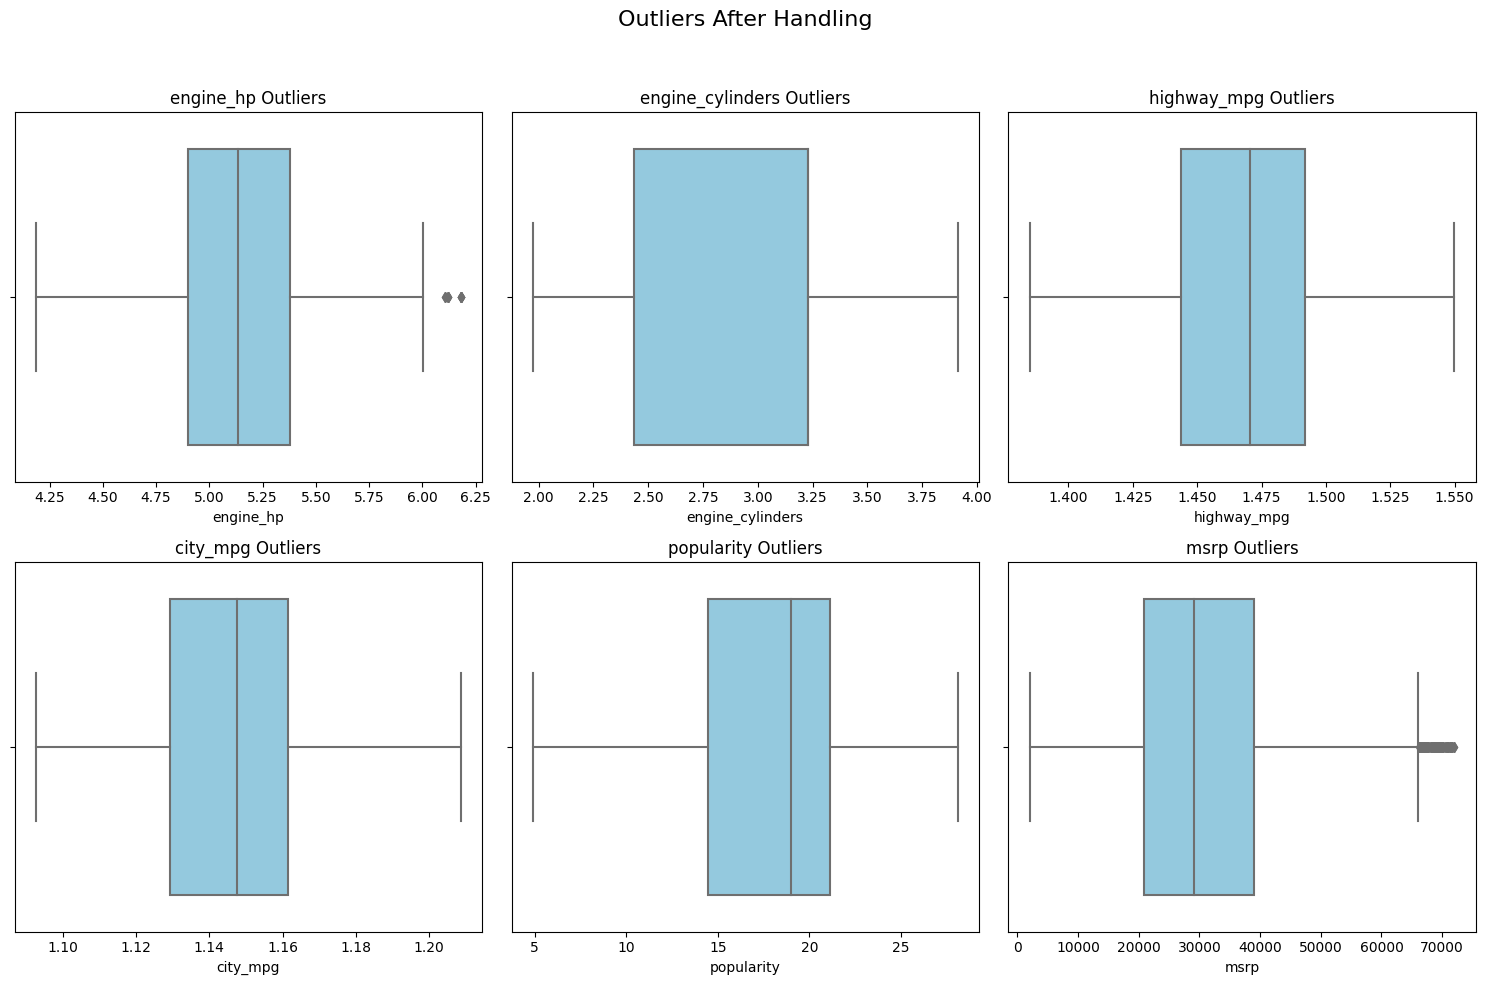

In [171]:
for col in numerical_columns_with_msrp:
    Q1 = dtf[col].quantile(0.25)  # First quartile (25th percentile)
    Q3 = dtf[col].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1                 # Interquartile range

    lower_bound = Q1 - 1.5 * IQR  # Lower bound
    upper_bound = Q3 + 1.5 * IQR  # Upper bound

        # Remove outliers outside the bounds
    dtf = dtf[(dtf[col] >= lower_bound) & (dtf[col] <= upper_bound)]

visualize_outliers(dtf, numerical_columns_with_msrp, "Outliers After Handling")

#### **Key Observations**:
1. **`engine_hp`**:
   - Most outliers have been removed, with only a couple of points remaining close to the upper boundary. The feature now has a more compact range.
   
2. **`engine_cylinders`**:
   - All extreme values beyond 6 cylinders have been removed, resulting in a clean distribution.

3. **`highway_mpg` & `city_mpg`**:
   - Both features now exhibit tighter ranges, with outliers on the higher end effectively removed. The distributions are more representative of the majority of the data.

4. **`popularity`**:
   - The feature's range has been reduced, eliminating extreme popularity values that could bias the model.

5. **`msrp`**:
   - Significant outliers (e.g., luxury car prices above $1,000,000) have been capped or removed, creating a more focused distribution of the target variable. However, a few points at the upper boundary remain, which might still be valid high-value instances.


### Data Preparation: Encoding and Saving Unmodified Data

In this step, we prepared two datasets:

1. **Encoded Data**:
   - We applied one-hot encoding to the categorical columns in the dataset (`X`) to make them compatible with the new model. This ensures that categorical features are represented numerically.

2. **Unmodified Data**:
   - We saved the unmodified dataset (`X_old`) without encoding categorical features. This will be used to evaluate the old model, ensuring a fair comparison with its original training conditions.

Finally, we split both datasets into training and testing subsets using an 80/20 split ratio. This allows us to train and evaluate the models on consistent splits for a meaningful comparison.


In [172]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb

X = dtf.drop(columns=['msrp'])  # Replace 'msrp' with your target column
y = dtf['msrp']

X_old = no_change_dtf.select_dtypes(include=[np.number]).drop(columns=['msrp'])
y_old = no_change_dtf['msrp']

# Detect and encode categorical columns
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_old, X_test_old, y_train_old, y_test_old = train_test_split(X_old, y_old, test_size=0.2, random_state=42)

In [173]:
new_model = xgb.XGBRegressor(random_state=42)
new_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [174]:
y_pred_old = xgb_model.predict(X_test_old)
mae_old = mean_absolute_error(y_test_old, y_pred_old)
mse_old = mean_squared_error(y_test_old, y_pred_old)
rmse_old = np.sqrt(mse_old)
r2_old = r2_score(y_test_old, y_pred_old)

# Predictions and evaluation for the new model
y_pred_new = new_model.predict(X_test)
mae_new = mean_absolute_error(y_test, y_pred_new)
mse_new = mean_squared_error(y_test, y_pred_new)
rmse_new = np.sqrt(mse_new)
r2_new = r2_score(y_test, y_pred_new)

# Create a comparison table
comparison = pd.DataFrame({
    "Metric": ["MAE", "MSE", "RMSE", "R²"],
    "Old Model": [mae_old, mse_old, rmse_old, r2_old],
    "New Model": [mae_new, mse_new, rmse_new, r2_new]
})

# Disable scientific notation in pandas
pd.set_option('display.float_format', '{:.2f}'.format)
# Display the comparison
print(comparison)

  Metric     Old Model  New Model
0    MAE      19677.55    2289.69
1    MSE 1059311545.78 9762334.69
2   RMSE      32547.07    3124.47
3     R²          0.53       0.96


### Model Performance Comparison: Old Model vs. New Model

The comparison of the old model (trained on raw, unencoded data) and the new model (trained on encoded data) highlights significant improvements in predictive performance across all metrics:

---

#### **Key Improvements**:

1. **Mean Absolute Error (MAE)**:
   - The new model achieved an **MAE of 2,289.69**, a dramatic reduction from the old model's **19,677.55**.
   - This indicates that the new model's average prediction error is much smaller, demonstrating its improved accuracy.

2. **Mean Squared Error (MSE)**:
   - The new model's **MSE** decreased from **1,059,311,545.78** to **9,762,334.69**.
   - This significant drop shows that the new model is far better at minimizing large errors, which heavily impact the MSE metric.

3. **Root Mean Squared Error (RMSE)**:
   - The RMSE improved from **32,547.07** to **3,124.47**.
   - The lower RMSE reflects the new model's enhanced ability to generalize and handle variations in the data effectively.

4. **R² Score**:
   - The R² score increased from **0.53** to **0.96**.
   - This substantial improvement indicates that the new model explains **96%** of the variance in the target variable, compared to just **53%** for the old model.


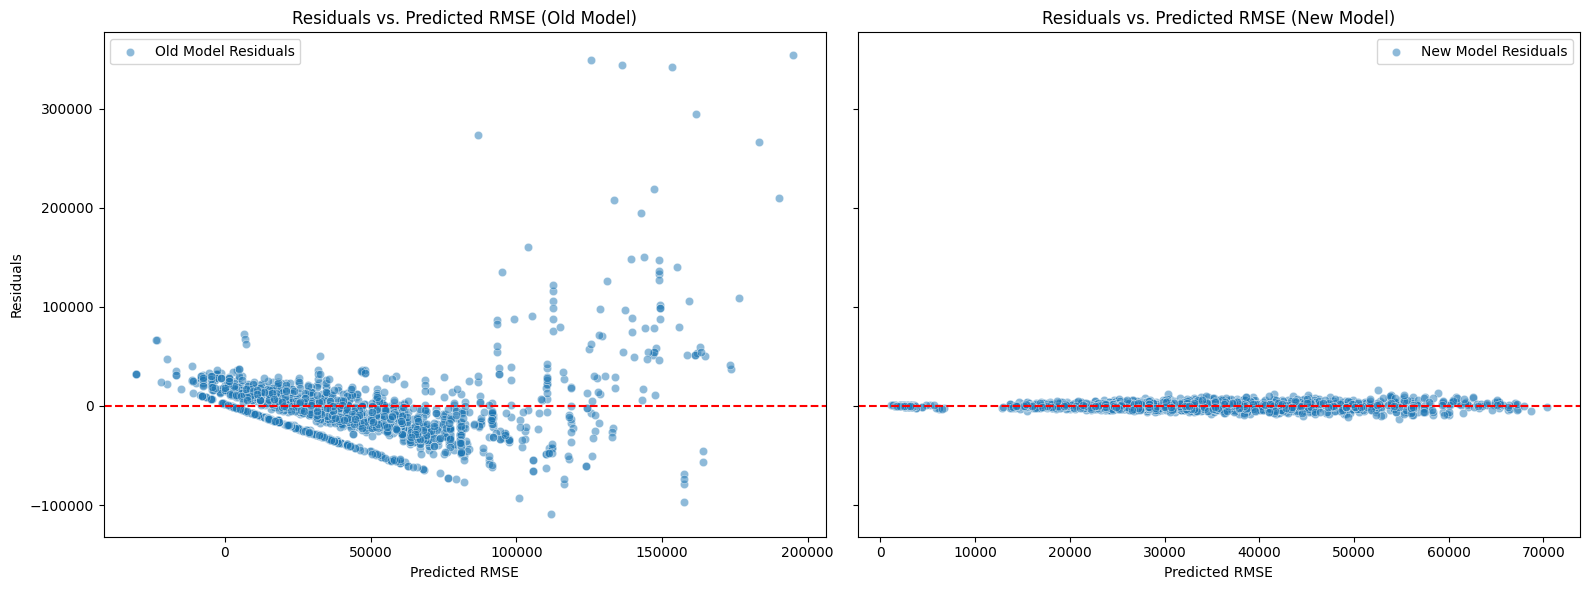

In [175]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_residuals(y_true, y_pred, model_name, ax):
    """
    Plot residuals vs. predicted values for a given model.

    Args:
        y_true: Actual values.
        y_pred: Predicted values.
        model_name: Name of the model (for labeling).
        ax: Matplotlib Axes object for plotting.
    """
    residuals = y_true - y_pred
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.5, ax=ax, label=f'{model_name} Residuals')
    ax.axhline(0, color='red', linestyle='--')
    ax.set_title(f'Residuals vs. Predicted RMSE ({model_name})')
    ax.set_xlabel('Predicted RMSE')
    ax.set_ylabel('Residuals')

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot residuals for old and new models
plot_residuals(y_test_old, y_pred_old, "Old Model", axes[0])
plot_residuals(y_test, y_pred_new, "New Model", axes[1])

plt.tight_layout()
plt.show()


### Residuals Comparison: Old Model vs. New Model

The residuals plots show a clear improvement in the new model compared to the old one. 

- **Old Model**: The residuals are widely scattered, indicating large errors in predictions. Many data points deviate significantly from the predicted line, showing poor accuracy and generalization.

- **New Model**: The residuals are tightly clustered around zero, demonstrating much closer predictions to the actual values. This reflects the improved accuracy and reduced error variability of the new model after incorporating categorical encoding and enhancements.

The new model significantly narrows the gap between predictions and actual values, highlighting the success of the applied improvements.


In [176]:
# Calculate absolute errors for both models
errors_old = np.abs(y_test_old - y_pred_old)
errors_new = np.abs(y_test - y_pred_new)

# Create a DataFrame for easier analysis
results_df_old = pd.DataFrame({
    'Actual (Old)': y_test_old,
    'Predicted (Old)': y_pred_old,
    'Error (Old)': errors_old
}).reset_index(drop=True)

results_df_new = pd.DataFrame({
    'Actual (New)': y_test,
    'Predicted (New)': y_pred_new,
    'Error (New)': errors_new
}).reset_index(drop=True)

# Find the worst and best predictions for the old model
worst_predictions_old = results_df_old.sort_values(by='Error (Old)', ascending=False).head(10)
best_predictions_old = results_df_old.sort_values(by='Error (Old)', ascending=True).head(10)

# Find the worst and best predictions for the new model
worst_predictions_new = results_df_new.sort_values(by='Error (New)', ascending=False).head(10)
best_predictions_new = results_df_new.sort_values(by='Error (New)', ascending=True).head(10)

print("Worst Predictions (Old Model):")
print(worst_predictions_old)

print("\tWorst Predictions (New Model):")
print(worst_predictions_new)

print("\nBest Predictions (Old Model):")
print(best_predictions_old)

print("\tBest Predictions (New Model):")
print(best_predictions_new)


Worst Predictions (Old Model):
      Actual (Old)  Predicted (Old)  Error (Old)
583         548800        194916.98    353883.02
2170        474990        125595.16    349394.84
231         479775        136167.61    343607.39
831         495000        153411.94    341588.06
1354        456500        161569.88    294930.12
1745        359990         86834.35    273155.65
1499        450000        183285.61    266714.39
36          366000        147169.03    218830.97
1756        399500        190030.50    209469.50
2123        340990        133375.44    207614.56
	Worst Predictions (New Model):
      Actual (New)  Predicted (New)  Error (New)
1960         68400         52590.91     15809.09
637          41135         54736.21     13601.21
288          71450         58834.30     12615.70
942          42870         30352.00     12518.00
885          54025         41607.65     12417.35
1954         37815         49405.20     11590.20
745          55970         45162.07     10807.93
1685  

SHAP Importance for Old Model:


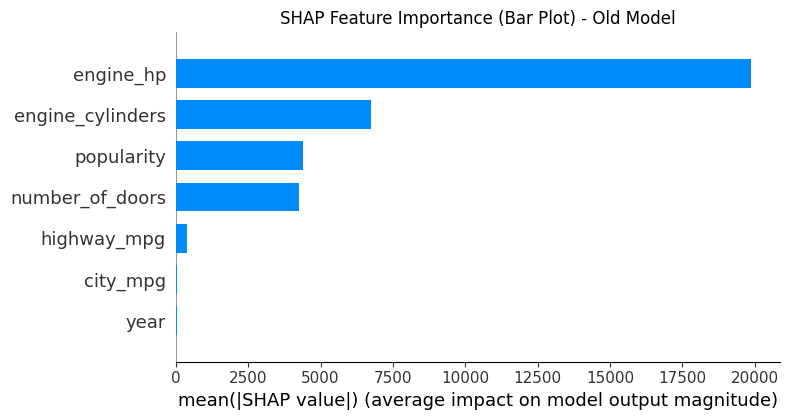

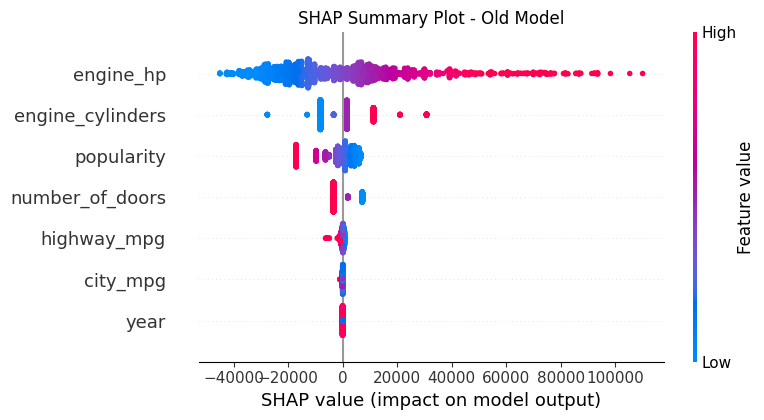

SHAP Importance for New Model:


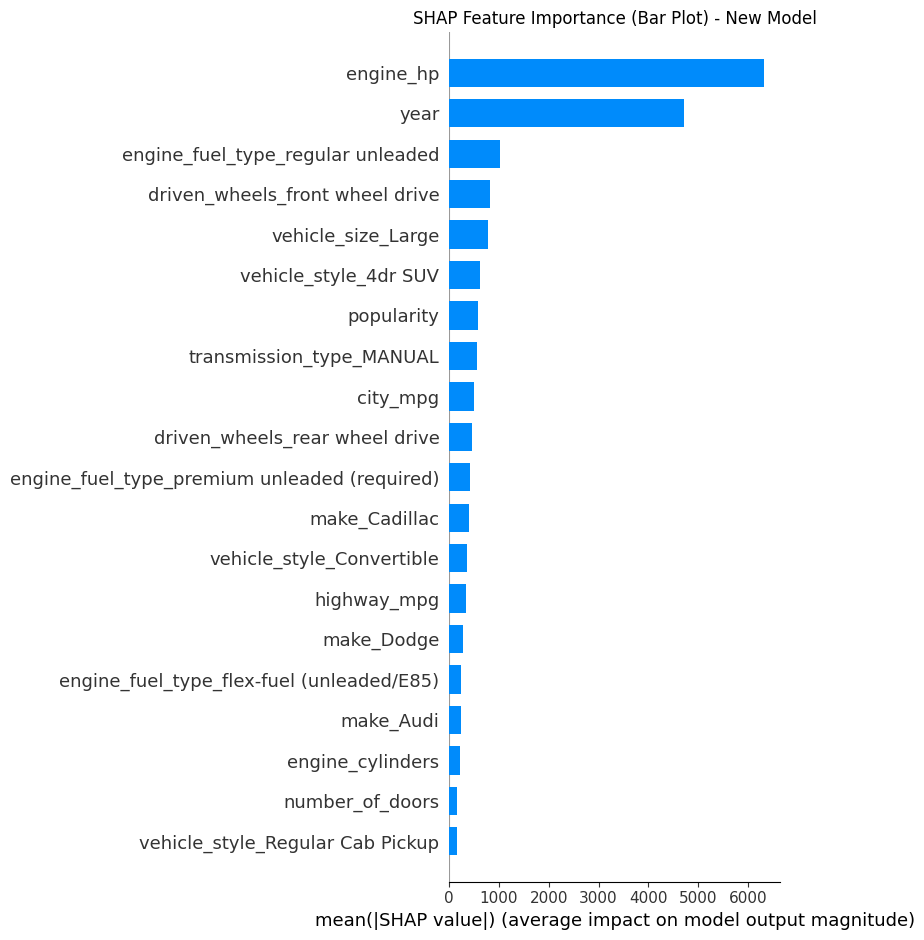

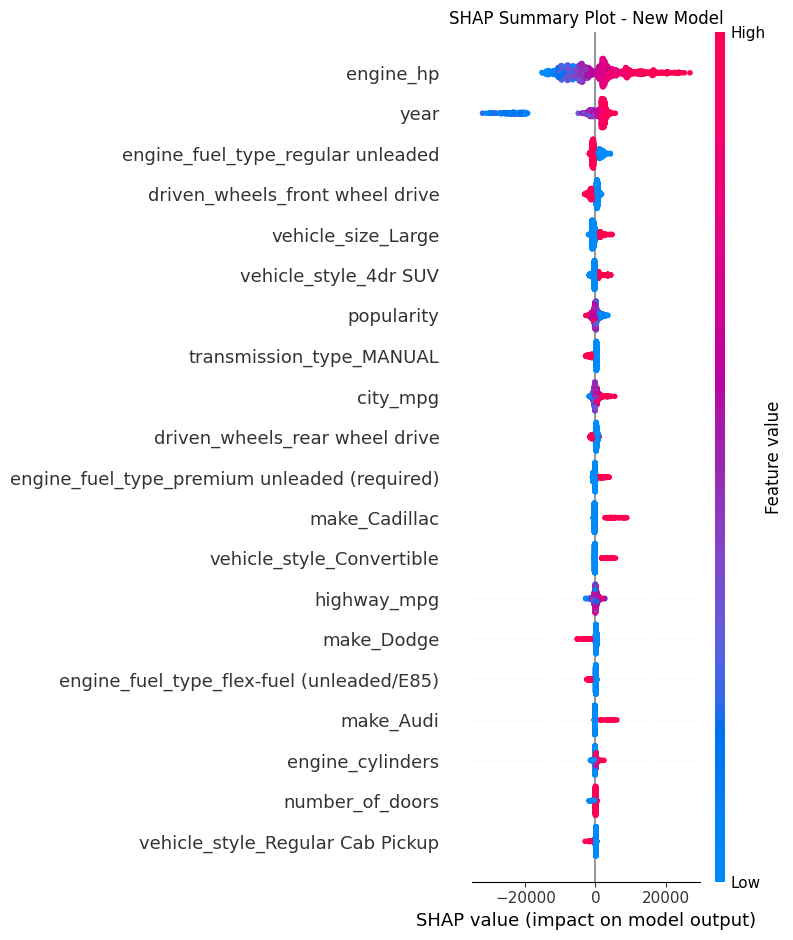

In [177]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

def shap_importance(model, x_train, x_test, title):
    # Create SHAP explainer
    explainer = shap.Explainer(model, x_train)
    shap_values = explainer(x_test)
    
    # Bar plot for global feature importance
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, x_test, plot_type="bar", show=False)
    plt.title(f"SHAP Feature Importance (Bar Plot) - {title}")
    plt.tight_layout()
    plt.show()
    
    # Detailed summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, x_test, show=False)
    plt.title(f"SHAP Summary Plot - {title}")
    plt.tight_layout()
    plt.show()

# Align the test data to match the training data structure
X_test_old_aligned = X_test_old[X_train_old.columns]
X_test_new_aligned = X_test[X_train.columns]

# Generate SHAP importance plots
print("SHAP Importance for Old Model:")
shap_importance(xgb_model, X_train_old, X_test_old, "Old Model")

print("SHAP Importance for New Model:")
shap_importance(new_model, X_train, X_test, "New Model")


### Insights from SHAP Analysis of Old and New Models

Both the old model and the new model identified a negative correlation between certain numerical features (e.g., `engine_hp`) and the target variable `msrp`. This aligns with the intuition and observations discussed in Part 1. However, the new model's results appear more conclusive and consistent, owing to the enriched dataset with encoded categorical features.

#### Key Observations:

1. **Importance of Previously Missed Features**:
   In the old model, categorical features like `make`, `vehicle_size`, and `engine_fuel_type` were entirely absent. These features turned out to be significant contributors to the model's predictions in the new model. For example, drivetrain types and vehicle styles clearly influenced the price predictions in ways that were not captured before.

2. **Increased Stability in Predictions**:
   The new model shows no features with extreme SHAP values compared to the old model. This is likely due to the encoding of categorical data, which provided a more structured representation of the dataset. Additionally, the cleaner dataset in the new model (after handling categorical variables) reduced the noise, resulting in more stable predictions.

3. **Emergence of Patterns**:
   Features like `vehicle_size` and `engine_fuel_type` exhibit clear patterns in their influence on predictions. For example, larger vehicles or specific fuel types tend to have a predictable impact on the `msrp`. These patterns align well with expectations based on domain knowledge, adding confidence in the new model's interpretability.

4. **Interaction Effects**:
   The new model demonstrates the combined influence of features more effectively. For instance, the interplay between numerical features (`engine_hp`, `year`) and categorical features (`make`, `transmission_type`) highlights a nuanced understanding of price prediction that the old model lacked.

5. **Weakness in the Old Model**:
   The old model struggled to incorporate relationships involving categorical variables, resulting in less precise predictions. For instance, features like `driven_wheels` were missing entirely in Part 1, despite their clear importance in influencing vehicle prices.

---

### Conclusion:
The new model's inclusion of encoded features has dramatically improved the interpretability and accuracy of predictions. While the old model provided some basic insights, the new model's ability to capture complex relationships and patterns makes it a far more robust and reliable tool for understanding the factors driving car prices.


## 4. Drawing Conclusions About the Data & Creative Applications

### **Feature Significance**
The improved model highlights key features that strongly influence vehicle MSRP (Manufacturer’s Suggested Retail Price):

- **Engine Horsepower (`engine_hp`)**: This was the most influential feature in both models, reaffirming that the power of a vehicle is a primary determinant of its price.
- **Manufacturing Year (`year`)**: The new model demonstrated that newer vehicles generally command higher prices, with a clear trend captured by this feature.
- **Fuel Type and Driven Wheels**: The encoded categorical features, such as `engine_fuel_type` and `driven_wheels`, turned out to provide significant insights. For instance, vehicles with premium fuel and all-wheel drive are generally priced higher.
- **Vehicle Size and Style**: Features like `vehicle_size` and `vehicle_style` were shown to influence pricing. Larger vehicles and SUVs appear to be priced higher than smaller sedans, aligning with market trends.
- **Popularity and Brand (`make`)**: Encoding categorical features like `make` brought out brand-specific effects on MSRP, which were previously obscured in the baseline model.

---

### **Biases or Trends**
- **Correlations and Patterns**:
  - A strong positive correlation exists between engine horsepower and MSRP, as expected.
  - The year of manufacture showed a direct relationship with MSRP, highlighting depreciation trends in older vehicles.
  - Vehicle size and style demonstrated consumer preferences, with SUVs and larger vehicles being valued higher.
- **Market Bias**:
  - The model revealed an implicit bias toward popular brands and vehicle types. Brands like Cadillac and Dodge were influential, suggesting their market perception impacts pricing significantly.

---

### **Data Insights**
- **Surprising Findings**:
  - Features such as the number of doors and some vehicle styles (e.g., `convertibles`) had smaller-than-expected impacts, indicating that consumer preferences prioritize performance and size over these features.
  - The introduction of encoded categorical variables exposed relationships that were not evident in the baseline model. For example, vehicle brand and style had a nuanced impact that only surfaced after encoding.
- **Cleaned Dataset Impact**:
  - Removing outliers and properly handling categorical data significantly reduced variability in predictions. The refined dataset provided cleaner insights into feature importance and relationships.

---

### **Potential Applications**
1. **Real-World Use Cases**:
   - **Dynamic Pricing Tools**: Develop a tool for dealerships to dynamically predict vehicle prices based on key attributes like year, engine performance, and style. This could optimize pricing strategies.
   - **Consumer Decision Support**: Build a consumer-facing platform to help buyers evaluate whether a vehicle is priced fairly, considering its specifications and market trends.
   - **Market Trend Analysis**: Provide insights into evolving consumer preferences (e.g., increasing demand for SUVs or electric vehicles).

2. **Predictive Tools for Stakeholders**:
   - **Insurance Premium Estimation**: Utilize the model to assist insurance companies in estimating premiums based on vehicle attributes.
   - **Manufacturer Strategy**: Help manufacturers decide on features to emphasize (e.g., engine power, fuel type) for better market alignment.

3. **Creative Applications**:
   - **Marketing Campaigns**: Use the insights to tailor marketing campaigns. For instance, highlight features like engine performance and size when targeting high-end consumers.
   - **Targeting Emerging Markets**: Predict and recommend vehicle types that are likely to perform well in specific regions based on pricing and consumer trends.

---

### **Summary**
The improved model not only enhanced predictive accuracy but also unlocked meaningful insights into vehicle pricing dynamics. By leveraging these findings, businesses can make data-driven decisions in pricing, marketing, and production. Furthermore, these models can form the basis for tools and strategies that enhance stakeholder outcomes across the automotive industry.
